In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.param_util as param_util
from lenstronomy.Data.pixel_grid import PixelGrid
import lenstronomy.Util.image_util as image_util
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import Planck13

%matplotlib inline

/fred/oz149/Tyler/pyenv/pytorch/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Light Model

In [ ]:
# SOURCE
source_light_model_list = ['SERSIC_ELLIPSE']
source_centre_x = 0.3
source_centre_y = 0
e1_source, e2_source = param_util.phi_q2_ellipticity(phi=0, q=0.9)
kwargs_source_light = [{'amp': 500, 'R_sersic': 0.1, 'n_sersic': 4, 'e1': e1_source, 'e2': e2_source, 'center_x': source_centre_x, 'center_y': source_centre_y}]

lightModel_source = LightModel(light_model_list=source_light_model_list)

# LENS
lens_light_model_list = ['SERSIC_ELLIPSE']
e1_lens, e2_lens = param_util.phi_q2_ellipticity(phi=0, q=1)
kwargs_lens_light = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 4, 'e1': 0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}]

lightModel_lens = LightModel(light_model_list=lens_light_model_list)

# Lens Model

/tmp/ipykernel_3995480/399248559.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


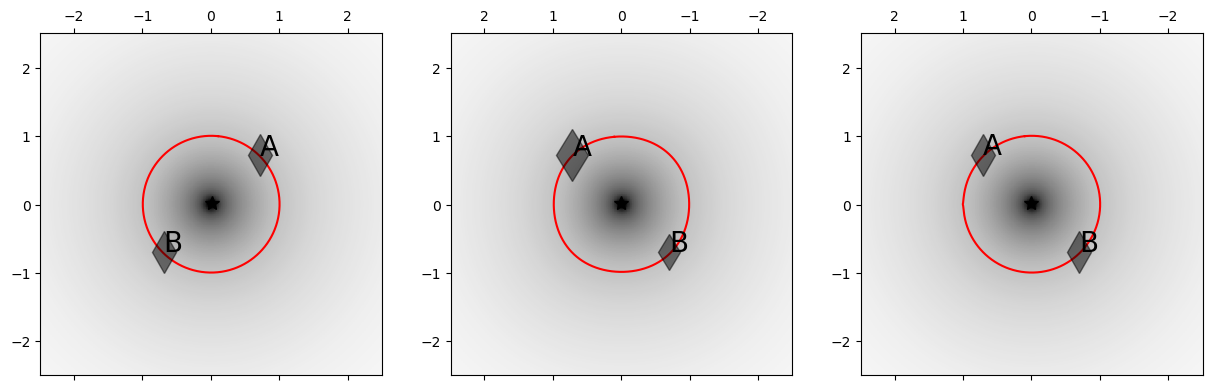

In [ ]:
# SIE
sie_lens_model_list = ['SIE']
kwargs_sie = [{'theta_E': 1, 'e1': e1_lens, 'e2': e2_lens, 'center_x': 0, 'center_y': 0}]
lensModel_sie = LensModel(lens_model_list=sie_lens_model_list)

# EPL+OCTOPOLE
boxydisky_lens_model_list = ['EPL_BOXYDISKY']
kwargs_boxydisky = [{'theta_E': 1, 'gamma': 2, 'e1': e1_lens, 'e2': e2_lens, 'center_x': 0, 'center_y': 0, 'a_m': -0.01}]
lensModel_boxydisky = LensModel(lens_model_list=boxydisky_lens_model_list)

# SIE+TNFW
lensCosmo = LensCosmo(z_lens=0.5, z_source=1, cosmo=Planck13)
Rs_angle, alpha_Rs = lensCosmo.nfw_physical2angle(10**8, 6)

sie_tnfw_lens_model_list = ['SIE', 'TNFW']
kwargs_sie_tnfw = [{'theta_E': 1, 'e1': e1_lens, 'e2': e2_lens, 'center_x': 0, 'center_y': 0}, 
                   {'Rs': Rs_angle, 'alpha_Rs': alpha_Rs, 'r_trunc': 5*0.1, 'center_x': 1, 'center_y': 0}]
lensModel_sie_tnfw = LensModel(lens_model_list=sie_tnfw_lens_model_list)


# VISUALIZATION
f, axex = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex[0], lensModel=lensModel_sie, kwargs_lens=kwargs_sie, sourcePos_x=source_centre_x, sourcePos_y=source_centre_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
lens_plot.lens_model_plot(axex[1], lensModel=lensModel_boxydisky, kwargs_lens=kwargs_boxydisky, sourcePos_x=source_centre_x, sourcePos_y=source_centre_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=True)
lens_plot.lens_model_plot(axex[2], lensModel=lensModel_sie_tnfw, kwargs_lens=kwargs_sie_tnfw, sourcePos_x=source_centre_x, sourcePos_y=source_centre_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=True)
f.show()

# Data Model

In [4]:
# import the PixelGrid() class #
deltaPix = 0.05  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.08,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

# Image Model

/fred/oz149/Tyler/pyenv/pytorch/lib/python3.10/site-packages/lenstronomy/LensModel/Profiles/epl.py:285: RuntimeWarning: invalid value encountered in true_divide
  R_omega = Z*hyp2f1(1, t/2, 2-t/2, -(1-q)/(1+q)*(Z/Z.conj()))
/tmp/ipykernel_3995480/537955756.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


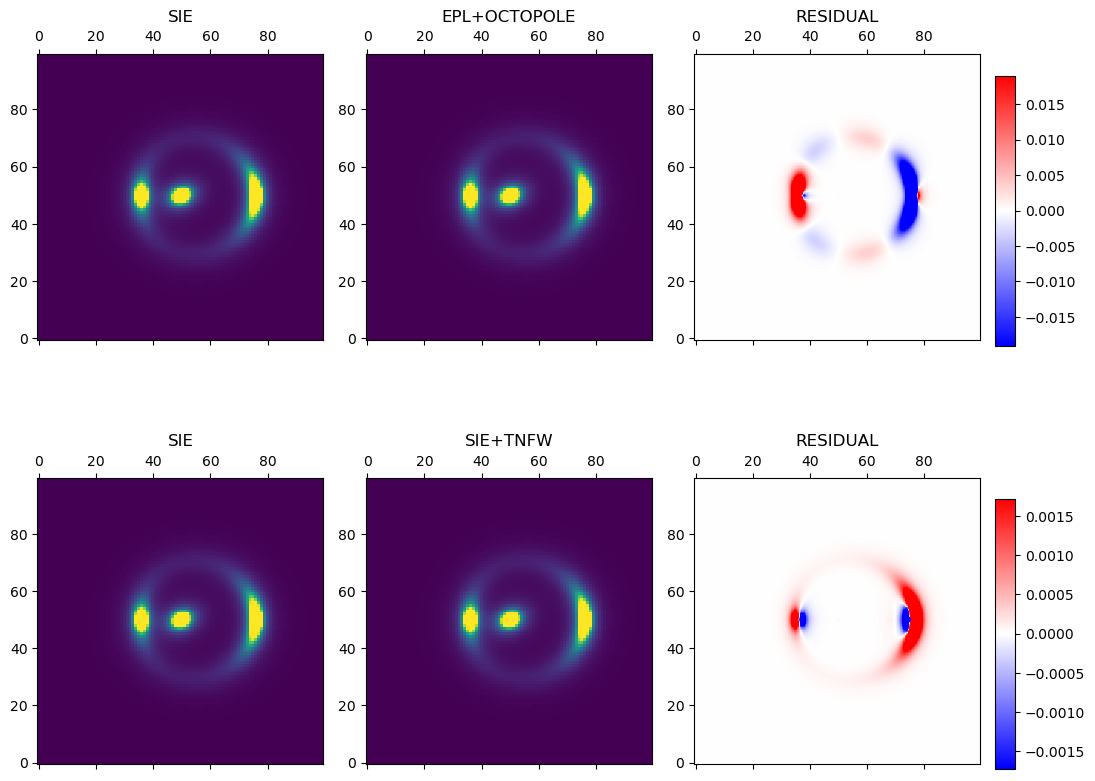

In [5]:
# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}

# SIE
# initialize the Image model class by combining the modules we created above #
imageModel_sie = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_sie,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image_sie = imageModel_sie.image(kwargs_lens=kwargs_sie, kwargs_source=kwargs_source_light,
                         kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_psf)

# EPL_OCTOPOLE
# initialize the Image model class by combining the modules we created above #
imageModel_boxydisky = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_boxydisky,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image_boxydisky = imageModel_boxydisky.image(kwargs_lens=kwargs_boxydisky, kwargs_source=kwargs_source_light,
                         kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_psf)

# SIE+TNFW
# initialize the Image model class by combining the modules we created above #
imageModel_sie_tnfw = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_sie_tnfw,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image_sie_tnfw = imageModel_sie_tnfw.image(kwargs_lens=kwargs_sie_tnfw, kwargs_source=kwargs_source_light,
                         kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_psf)


# exp_time = 100  # exposure time to quantify the Poisson noise level
# background_rms = 0.1  # background rms value
# poisson = image_util.add_poisson(image, exp_time=exp_time)
# bkg = image_util.add_background(image, sigma_bkd=background_rms)

vmax = np.percentile(image_sie, 99)

# take the largest of the absolute values of the max and min values
vmax_residual = np.max([np.abs(np.percentile(image_boxydisky-image_sie, 99)), np.abs(np.percentile(image_boxydisky-image_sie, 1))])


f, axes = plt.subplots(2, 3, figsize=(10, 9))
axes[0,0].matshow(image_sie, origin='lower', vmax=vmax)
axes[0,1].matshow(image_boxydisky, origin='lower', vmax=vmax)
axes[0,2].matshow(image_boxydisky-image_sie, origin='lower', cmap='bwr',vmax=vmax_residual, vmin=-vmax_residual )

axes[0,0].set_title("SIE")
axes[0,1].set_title("EPL+OCTOPOLE")
axes[0,2].set_title("RESIDUAL")

# add colourbar to the third plot
cax = f.add_axes([1, 0.57, 0.02, 0.3])
f.colorbar(axes[0,2].imshow(image_boxydisky-image_sie, origin='lower', cmap='bwr', vmax=vmax_residual, vmin=-vmax_residual), cax=cax)

vmax_residual = np.max([np.abs(np.percentile(image_sie_tnfw-image_sie, 99)), np.abs(np.percentile(image_sie_tnfw-image_sie, 1))])

axes[1,0].matshow(image_sie, origin='lower', vmax=vmax)
axes[1,1].matshow(image_sie_tnfw, origin='lower', vmax=vmax)
axes[1,2].matshow(image_sie_tnfw-image_sie, origin='lower', cmap='bwr', vmax=vmax_residual, vmin=-vmax_residual)

axes[1,0].set_title("SIE")
axes[1,1].set_title("SIE+TNFW")
axes[1,2].set_title("RESIDUAL")

# add colourbar to the third plot
cax = f.add_axes([1, 0.1, 0.02, 0.3])
f.colorbar(axes[1,2].imshow(image_sie_tnfw-image_sie, origin='lower', cmap='bwr', vmax=vmax_residual, vmin=-vmax_residual), cax=cax)

f.tight_layout()
plt.show()